### Stock Trading Strategy using Classification Algorithms to Predict Market Movements and Backtesting

In [1]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf # install with pip
import backtrader as bt
from backtrader.feeds import PandasData
import warnings

from surfingcrypto import Config,TS

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

/opt/miniconda3/envs/cryptoenv/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Gathering

In [3]:
c=Config("/Users/giorgiocaizzi/Documents/GitHub/surfingcrypto/config")
ticker="ETH"
ts=TS(c,coin=ticker)
ts.df

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2017-10-01 00:00:00+00:00,255.288687,256.747390,249.797667,256.044212,2.593030e+08,2.430109e+10
2017-10-02 00:00:00+00:00,256.167001,256.711876,250.857533,253.580263,2.893556e+08,2.407106e+10
2017-10-03 00:00:00+00:00,253.587078,256.395551,245.386642,248.989454,2.738634e+08,2.363906e+10
2017-10-04 00:00:00+00:00,249.237185,254.456920,247.380720,248.964687,2.194011e+08,2.364053e+10
2017-10-05 00:00:00+00:00,249.062535,254.518348,245.716713,252.593705,2.166371e+08,2.398902e+10
...,...,...,...,...,...,...
2022-04-14 00:00:00+00:00,2861.636568,2879.773008,2758.325789,2790.517183,1.461962e+10,3.359229e+11
2022-04-15 00:00:00+00:00,2790.725112,2817.905094,2776.531201,2812.565017,1.041136e+10,3.386148e+11
2022-04-16 00:00:00+00:00,2812.756135,2843.984427,2789.908987,2832.352308,8.108392e+09,3.410350e+11


In [4]:
# download ticker ‘Adj Close’ price from yahoo finance
stock=ts.df[["Close"]]
stock.rename(columns = {'Close':ticker}, inplace=True)
stock.tail(2)

,ETH
Date,
2022-04-17 00:00:00+00:00,2768.209553
2022-04-18 00:00:00+00:00,2836.202356


In [5]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.tail(3)

,ETH,returns,direction
Date,,,
2022-04-16 00:00:00+00:00,2832.352308,0.007011,1
2022-04-17 00:00:00+00:00,2768.209553,-0.022907,-1
2022-04-18 00:00:00+00:00,2836.202356,0.024265,1


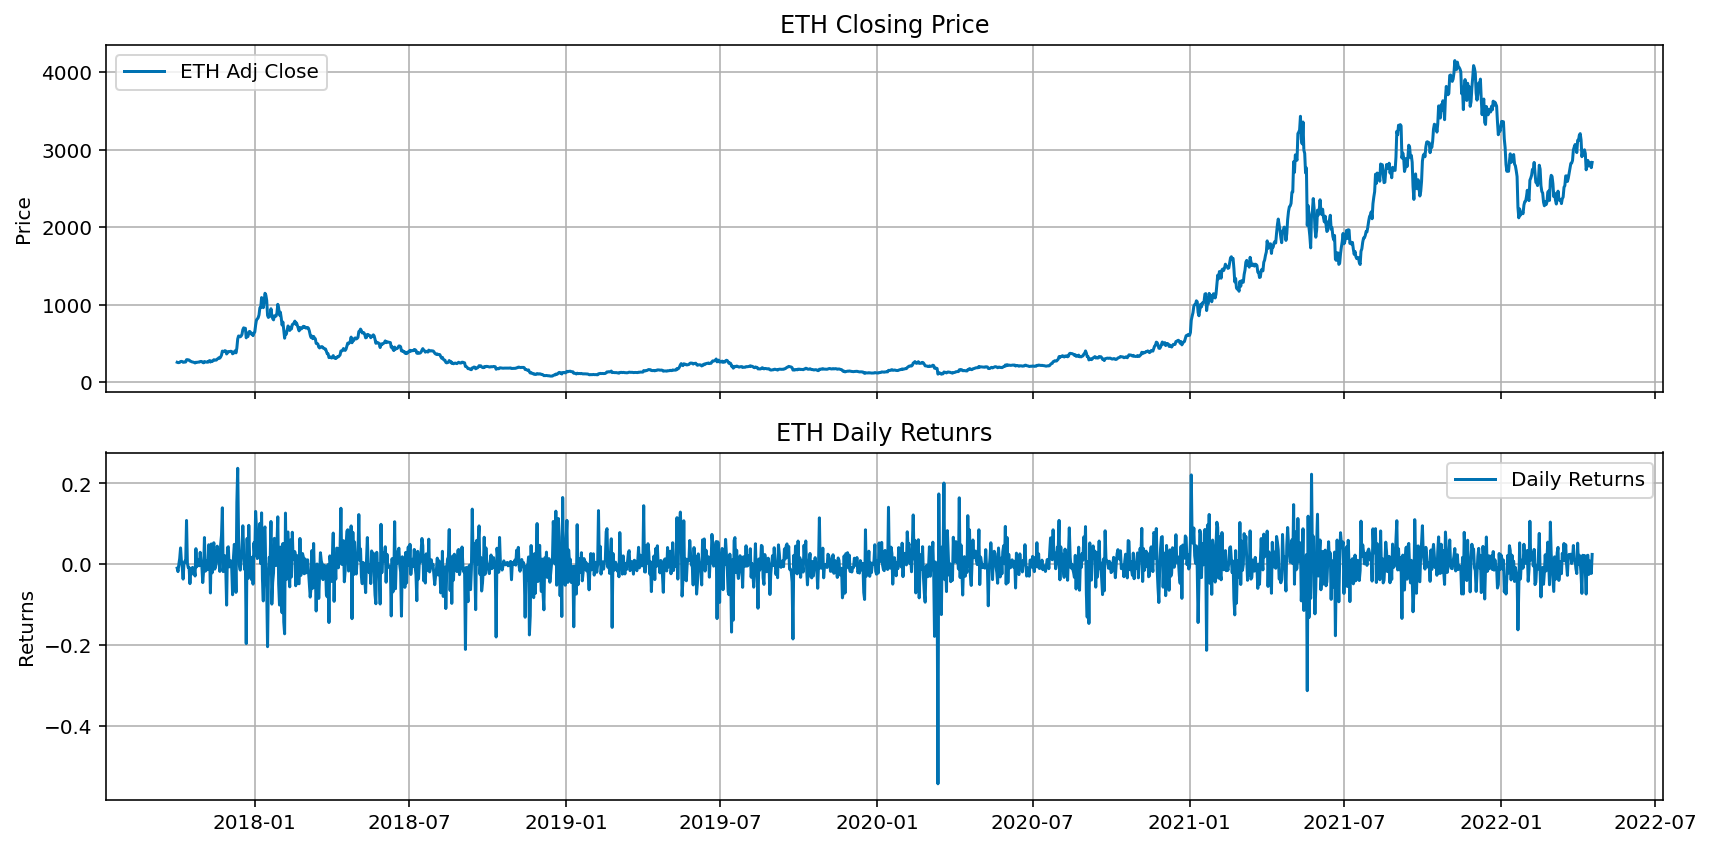

In [6]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
#plt.savefig('ichart1', dpi=300)

### Feature Engineering

In [7]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

In [8]:
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)

stock.dropna(inplace=True)
stock.tail(2)

,ETH,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
Date,,,,,,,,
2022-04-17 00:00:00+00:00,2768.209553,-0.022907,-1,0.007011,0.007870,-0.025334,0.022253,0.021096
2022-04-18 00:00:00+00:00,2836.202356,0.024265,1,-0.022907,0.007011,0.007870,-0.025334,0.022253


In [9]:
# cols

In [10]:
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [11]:
create_bins(stock)
stock[cols+cols_bin].tail(2)

,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,
2022-04-17 00:00:00+00:00,0.007011,0.007870,-0.025334,0.022253,0.021096,1,1,0,1,1
2022-04-18 00:00:00+00:00,-0.022907,0.007011,0.007870,-0.025334,0.022253,0,1,1,0,1


In [12]:
# cols_bin

### Build and Apply Classification Machine Learning Algorithms

Select Logistic regression, Gaussian Naive Bayes, Support Vector Machine, Random Forest, and MLP Classifier approaches to predict the market direction. Please refer sklearn documentation for detail on these and other algorithms.
https://scikit-learn.org/stable/index.html

In [13]:
# create a dictionary of selected algorithms
models = {
    'log_reg': linear_model.LogisticRegression(),
    'gauss_nb': GaussianNB(),
    'svm': SVC(),
    'random_forest': RandomForestClassifier(max_depth=10, n_estimators=100),
    'MLP' : MLPClassifier(max_iter=500),
}

In [14]:
# function that fits all models.
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()} 

In [15]:
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [16]:
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')

In [17]:
# fit the models
fit_models(stock)

In [18]:
# derives all position values
derive_positions(stock)

In [19]:
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)

In [20]:
# calculate total return and std. deviation of each strategy
print('\nTotal Returns:')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volatility:')
stock[strategy_rtn].std() * 252 ** 0.5


Total Returns:
returns                    10.783686
strategy_log_reg            0.330635
strategy_gauss_nb           0.445547
strategy_svm              114.762629
strategy_random_forest     27.213507
strategy_MLP                1.701295
dtype: float64

Annual Volatility:


returns                   0.814621
strategy_log_reg          0.814871
strategy_gauss_nb         0.814903
strategy_svm              0.813669
strategy_random_forest    0.814323
strategy_MLP              0.814924
dtype: float64

In [21]:
# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(stock['pos_random_forest'].diff()!=0).sum())

Number of trades SVM =  825
Number of trades Ramdom Forest =  913


In [22]:
# stock[[ticker]+ strategy_rtn].head(2)

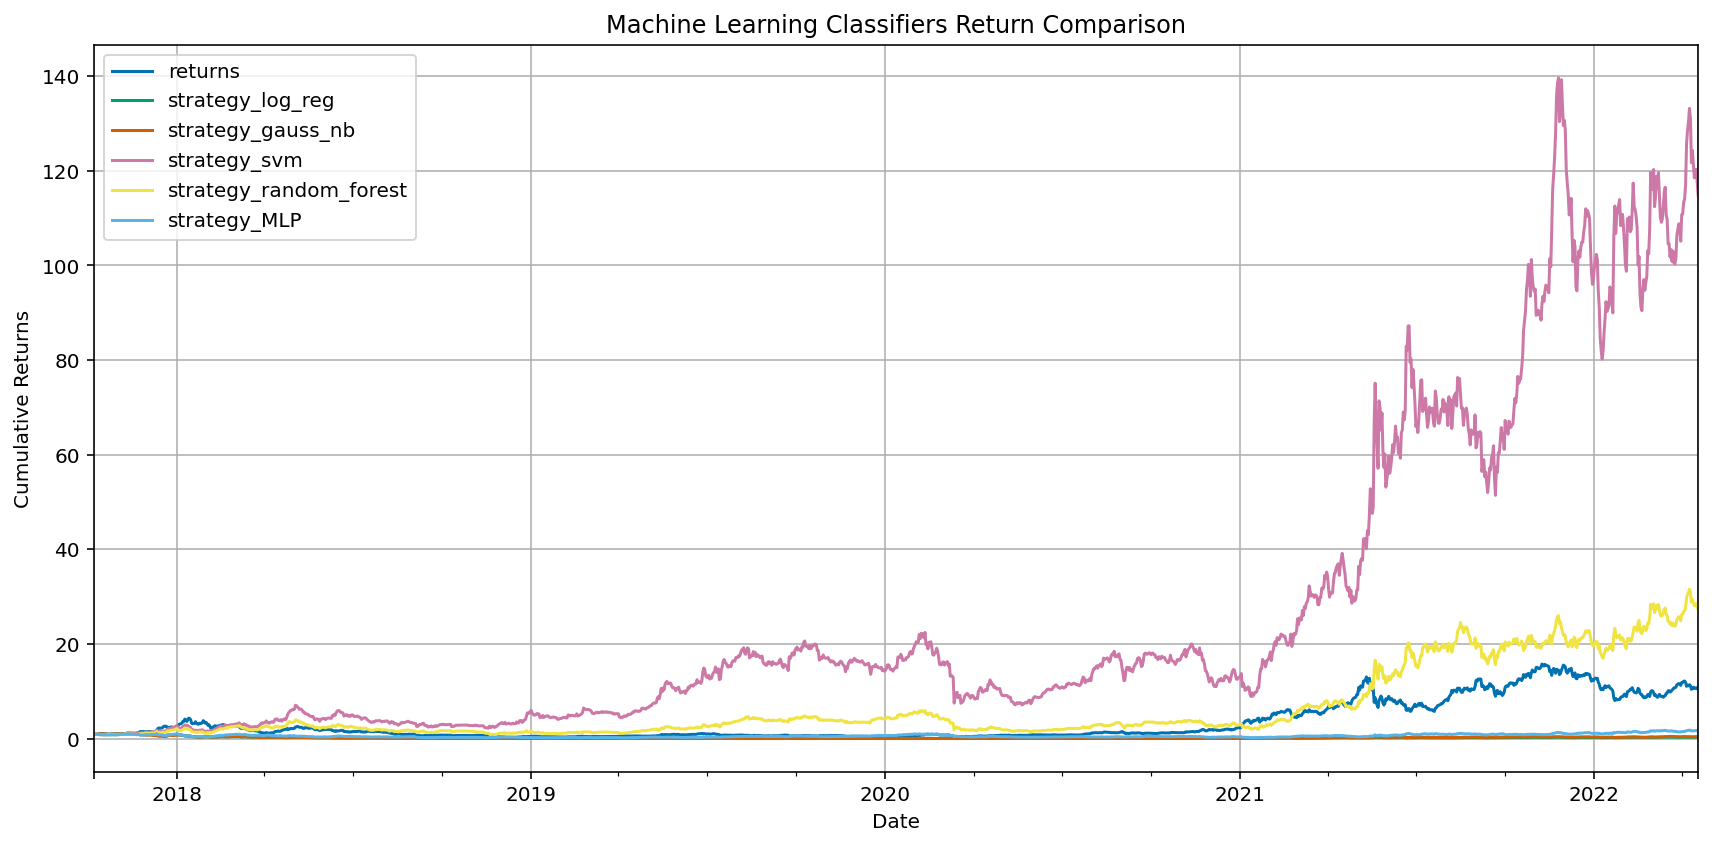

In [23]:
# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True);
plt.tight_layout();
# plt.savefig('images/chart2', dpi=300)

### Backtesting of Selected Strategy using Backtrader

In [24]:
prices=ts.df[["Open",	"High",	"Low","Close","Volume"]]
prices

,Open,High,Low,Close,Volume
Date,,,,,
2017-10-01 00:00:00+00:00,255.288687,256.747390,249.797667,256.044212,2.593030e+08
2017-10-02 00:00:00+00:00,256.167001,256.711876,250.857533,253.580263,2.893556e+08
2017-10-03 00:00:00+00:00,253.587078,256.395551,245.386642,248.989454,2.738634e+08
2017-10-04 00:00:00+00:00,249.237185,254.456920,247.380720,248.964687,2.194011e+08
2017-10-05 00:00:00+00:00,249.062535,254.518348,245.716713,252.593705,2.166371e+08
...,...,...,...,...,...
2022-04-14 00:00:00+00:00,2861.636568,2879.773008,2758.325789,2790.517183,1.461962e+10
2022-04-15 00:00:00+00:00,2790.725112,2817.905094,2776.531201,2812.565017,1.041136e+10
2022-04-16 00:00:00+00:00,2812.756135,2843.984427,2789.908987,2832.352308,8.108392e+09


In [25]:
prices=prices.loc["2021-04-20":]
prices

,Open,High,Low,Close,Volume
Date,,,,,
2021-04-20 00:00:00+00:00,1795.406406,1948.933827,1706.963044,1936.596366,3.277246e+10
2021-04-21 00:00:00+00:00,1937.385175,2050.270935,1864.219355,1964.593249,3.231665e+10
2021-04-22 00:00:00+00:00,1958.876844,2198.476428,1926.994656,2000.536891,4.459289e+10
2021-04-23 00:00:00+00:00,1998.640012,2029.987580,1756.581905,1953.619811,4.580233e+10
2021-04-24 00:00:00+00:00,1956.606164,1957.053944,1788.597500,1828.220570,2.633201e+10
...,...,...,...,...,...
2022-04-14 00:00:00+00:00,2861.636568,2879.773008,2758.325789,2790.517183,1.461962e+10
2022-04-15 00:00:00+00:00,2790.725112,2817.905094,2776.531201,2812.565017,1.041136e+10
2022-04-16 00:00:00+00:00,2812.756135,2843.984427,2789.908987,2832.352308,8.108392e+09


In [26]:
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume',
                         }, inplace=True)

In [27]:
prices.tail(3)

,open,high,low,close,volume
Date,,,,,
2022-04-16 00:00:00+00:00,2812.756135,2843.984427,2789.908987,2832.352308,8.108392e+09
2022-04-17 00:00:00+00:00,2831.956028,2844.806688,2764.178213,2768.209553,9.675953e+09
2022-04-18 00:00:00+00:00,2768.284022,2839.743948,2680.900556,2836.202356,1.728041e+10


In [28]:
strategy="strategy_svm"

In [29]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = stock[strategy]
predictions

Date
2017-10-07 00:00:00+00:00   -0.008184
2017-10-08 00:00:00+00:00    0.008886
2017-10-09 00:00:00+00:00   -0.036850
2017-10-10 00:00:00+00:00    0.002184
2017-10-11 00:00:00+00:00   -0.007579
                               ...   
2022-04-14 00:00:00+00:00   -0.025334
2022-04-15 00:00:00+00:00    0.007870
2022-04-16 00:00:00+00:00    0.007011
2022-04-17 00:00:00+00:00   -0.022907
2022-04-18 00:00:00+00:00   -0.024265
Name: strategy_svm, Length: 1655, dtype: float64

In [30]:
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {strategy:'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.tail(2)

,predicted,open,high,low,close,volume
Date,,,,,,
2022-04-17 00:00:00+00:00,-0.022907,2831.956028,2844.806688,2764.178213,2768.209553,9.675953e+09
2022-04-18 00:00:00+00:00,-0.024265,2768.284022,2839.743948,2680.900556,2836.202356,1.728041e+10


In [31]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [32]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [33]:
# https://www.backtrader.com/blog/posts/2019-08-29-fractional-sizes/fractional-sizes/

class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

In [34]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                # size = int(self.broker.getcash() / self.datas[0].open) #   this is for stocks
                size = self.broker.getcash() / self.datas[0].open #   this is for stocks

                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [35]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [36]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(1250.0)
cerebro.broker.setcommission(commission=0.05)
cerebro.broker.addcommissioninfo(CommInfoFractional()) # fractional
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [37]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1250.00
2021-04-23, BUY CREATED --- Size: 0.6254252852962077, Cash: 1250.00, Open: 1998.6400124644583, Close: 1953.6198106271845
2021-04-23, BUY EXECUTED --- Price: 1998.64, Cost: 1250.00,Commission: 0.00
2021-04-24, SELL CREATED --- Size: 0.6254252852962077
2021-04-24, SELL EXECUTED --- Price: 1956.61, Cost: 1250.00,Commission: 0.00
2021-04-24, OPERATION RESULT --- Gross: -26.29, Net: -26.29
2021-04-25, BUY CREATED --- Size: 0.6685026365084574, Cash: 1223.71, Open: 1830.5252684248487, Close: 1915.7472756507195
2021-04-25, BUY EXECUTED --- Price: 1830.53, Cost: 1223.71,Commission: 0.00
2021-04-26, SELL CREATED --- Size: 0.6685026365084574
2021-04-26, SELL EXECUTED --- Price: 1918.57, Cost: 1223.71,Commission: 0.00
2021-04-26, OPERATION RESULT --- Gross: 58.86, Net: 58.86
2021-04-27, BUY CREATED --- Size: 0.6113906152751541, Cash: 1282.57, Open: 2097.795285207118, Close: 2202.679525308113
2021-04-27, BUY EXECUTED --- Price: 2097.80, Cost: 1282.57,Commission: 0.

In [38]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.tail(2)

index
2022-04-17 00:00:00+00:00   -0.00014
2022-04-18 00:00:00+00:00    0.00000
Name: Strategy, dtype: float64

In [39]:
# get benchmark returns
benchmark_rets= stock['returns']
# benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Nifty-50'
benchmark_rets.tail(2)

Date
2022-04-17 00:00:00+00:00   -0.022907
2022-04-18 00:00:00+00:00    0.024265
Name: Nifty-50, dtype: float64

In [40]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2021-04-20
End date,2022-04-18
Total months,17
,Backtest
Annual return,213.629%
Cumulative returns,421.249%
Annual volatility,61.271%
Sharpe ratio,2.18
Calmar ratio,6.47
Stability,0.89
Max drawdown,-33.042%


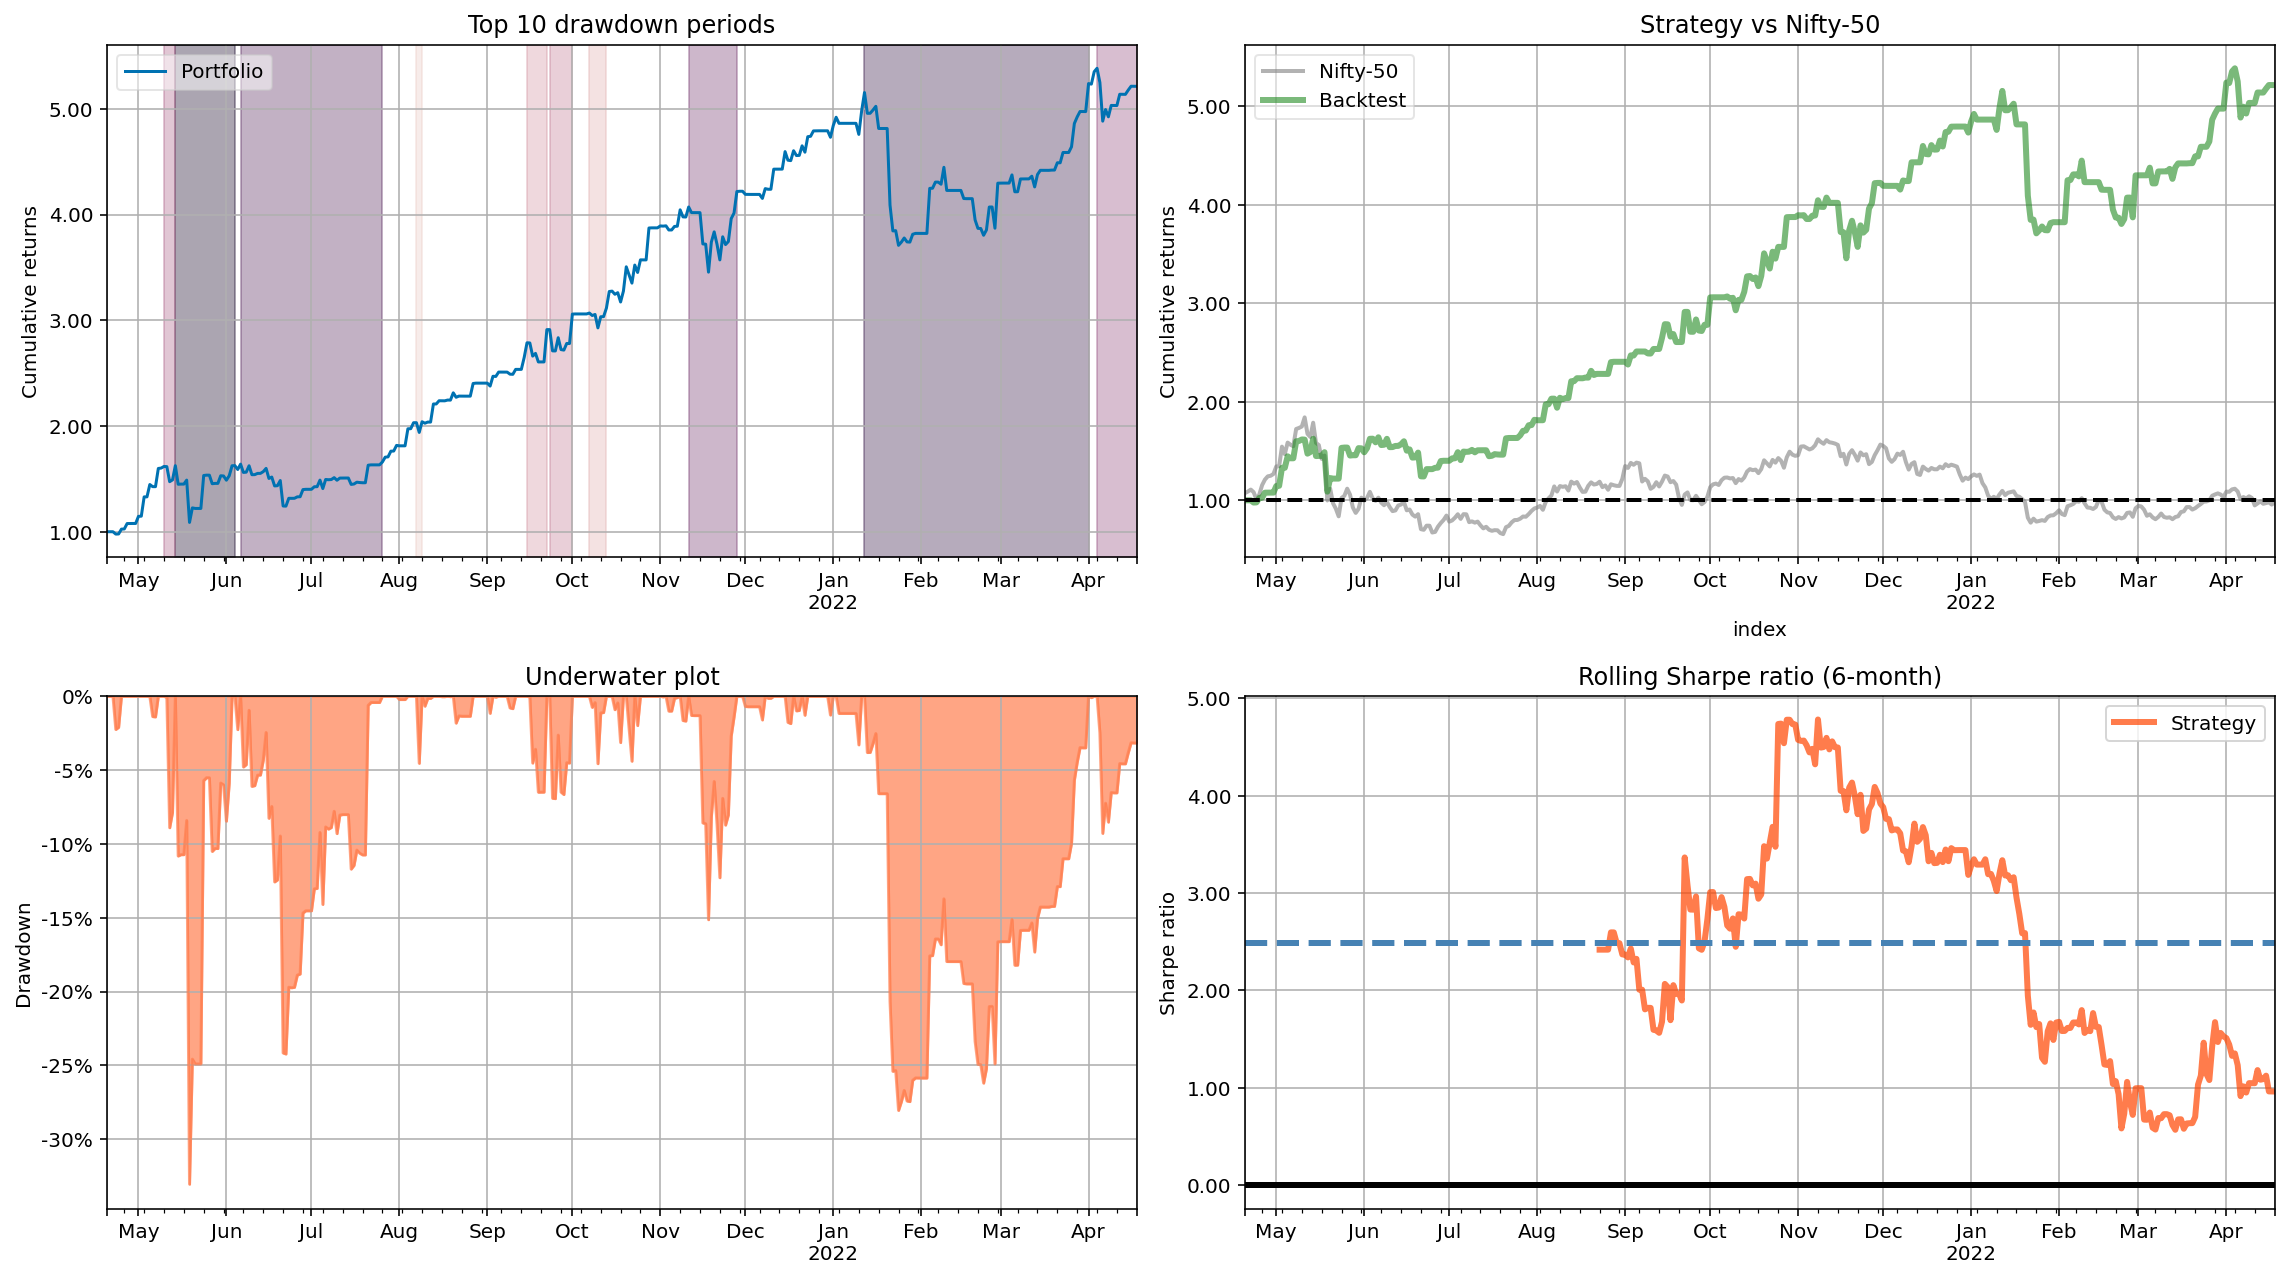

In [41]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs Nifty-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('Strategy vs Nifty-50 (Buy and Hold)', fontsize=16, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('images/chart3', dpi=300)

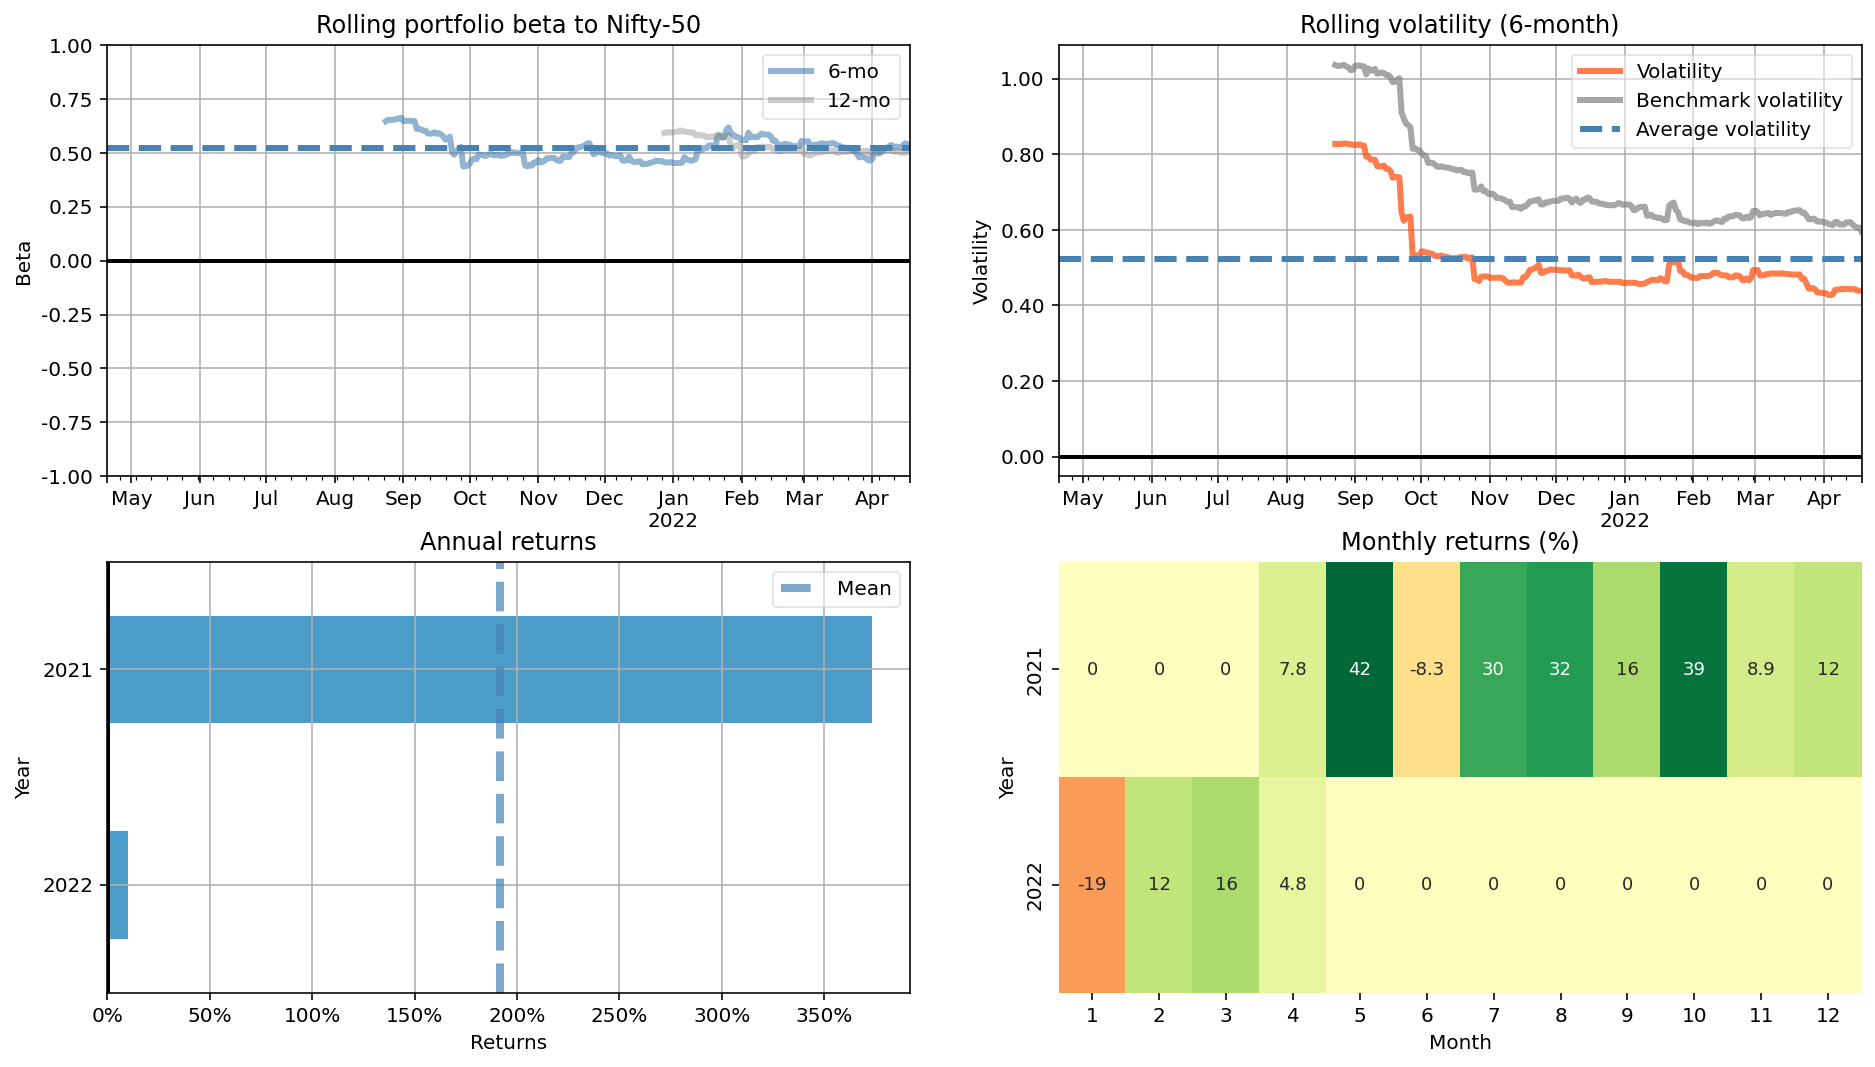

In [42]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
# fig.suptitle('BL Portfolio vs BSE-SENSEX - 2', fontsize=16, y=1.0)


plt.tight_layout()
# plt.savefig('images/chart4', dpi=300)